Implementing a part of the paper "Improved Training of Wasserstein GANs", by Gulrajani et al.
Implementation of the architecture designed for CIFAR10 (The simpler one, without residual layers, section F).
We will make appropriate modifications for MNIST. Then apply it on the Fashion MNIST data set.

Additionlay, we will:
a. Plot the loss function as a function of the iterations for training with the
DCGAN and the WGAN.
b. Select two "DCGAN" generated images, and two "WGAN" generated
images (preferably from the same label, or two labels), in addition to two real images (from the corresponding label).


In this paper, the authors first mentioned the Wasserstein-GANs, which use Wassertein distance for optimiziation, in addition to "weight clipping" (force weights to lie within a compact space [−c, c]) implied to the discriminator (or "critic") for it to be a k-Lliphshitz function (for all x1,x2: |x1-x2|>=|f(x1)-f(x2)|) - why? because k-Lliphshitz functions promise convergance for the Wassertein distance value.

then, the authors show that this method has limitations (optimization difficulties, or pathological value surface on succesfull optimization) on toy data, and propose gradiant penalty instead of weight clipping, to force 1-Lliphshitz generator for better training.

The WGAN authors claimed that the divergance (KL) used to train GANs are not continouos with the Genetator parameters (harming training), show that the "Earth-mover distance" (Wasserstein), under mild assumptions, is continuous everywhere and differentiable almost everywhere.
The value function is constructed using the Kantorovich-Rubinstein duality to obtain:



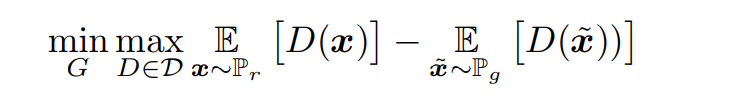

Assuming the discriminator is optimized, minimizing the objective w.r to the Generator's parameters minimizies W(P_r, P_g)
In the paper, the authors show that the optimal discriminator has a unit norm gradient everywhere under P_r and P_g. in addition: "A differentiable function
is 1-Lipschtiz if and only if it has gradients with norm at most 1 everywhere"

**when clipping the weights - the discriminator learned extremely simple functions**. ("ignores higher moments of the data distribution and instead models very simple approximations to the optimal functions"). In addition, **it does not suffer from vanishing or exploding gradients**: "interactions between the weight constraint and the cost function, result in either vanishing or exploding gradients"

How did they constrained the norm of the gradient? "To circumvent
tractability issues, we enforce a soft version of the constraint with a penalty on the gradient norm for random samples"

We implicitly define Pxˆ sampling uniformly along straight lines between
pairs of points sampled from the data distribution Pr and the generator distribution Pg

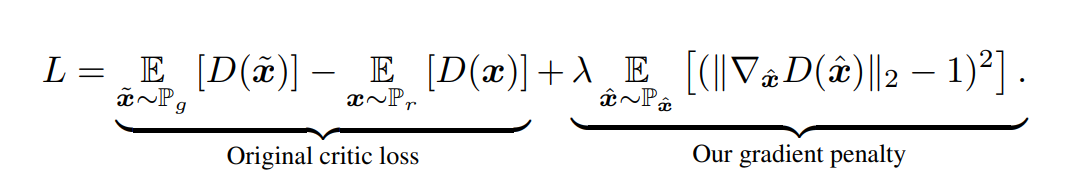

#### Data collection

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


In [2]:
import torchvision.transforms as transforms

transform = transforms.Compose(
        [transforms.Resize((32, 32)),  # Resize to 32x32
         transforms.ToTensor(),
         transforms.Normalize((0.5,), (0.5,))])

# Download train data from open datasets.
train_data= datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)

# Download test data from open datsets.
test_data=datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.7MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.94MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.31MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



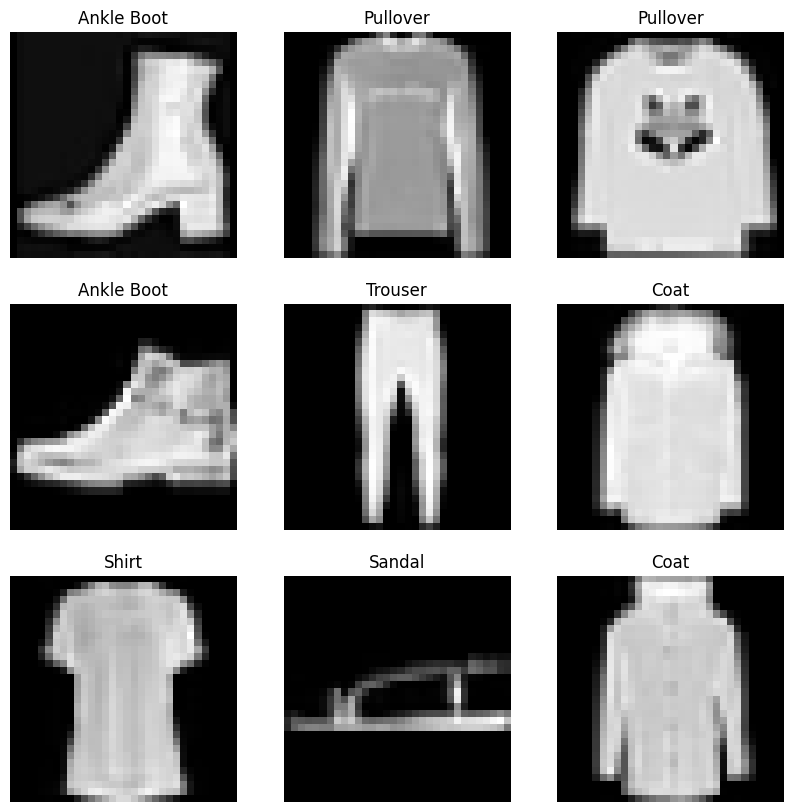

In [3]:
import matplotlib.pyplot as plt

labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

Shape of X [N, C, H, W]: torch.Size([64, 1, 32, 32])
Shape of y: torch.Size([64]) <built-in method type of Tensor object at 0x79d3d468f0b0>


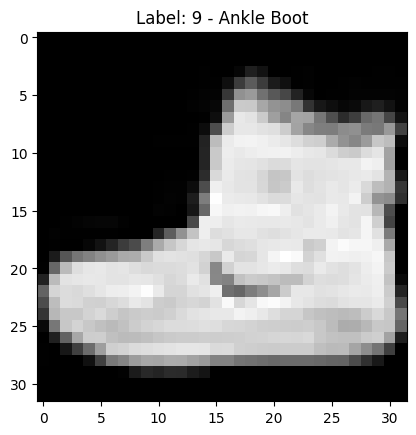

Labels batch shape: torch.Size([64])


In [4]:
# Define hyperparameter
batch_size = 64

# Create data loaders
train_dl= DataLoader(train_data, batch_size = batch_size)
test_dl = DataLoader(test_data, batch_size=batch_size)

for X,y in train_dl:
    train_features, train_labels = next(iter(train_dl))
    # N: number of samples, C: channels, H: height, W: weight
    print(f'Shape of X [N, C, H, W]: {X.shape}')
    print(f'Shape of y: {y.shape} {y.type}')
    image = train_features[0].squeeze() # Returns a tensor with all specified dimensions of input of size 1 removed.
    label = train_labels[0]
    plt.title(f"Label: {label} - {labels_map[label.item()]}")
    plt.imshow(image, cmap="gray")
    plt.show()
    print(f"Labels batch shape: {train_labels.shape}")
    break

#### Data exploration

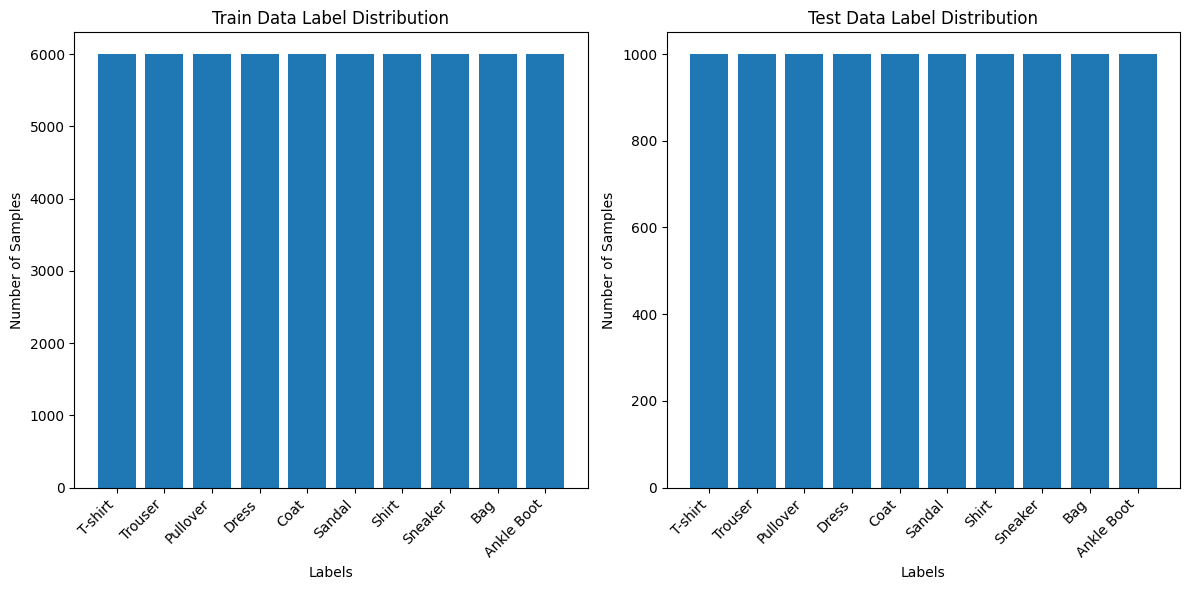

In [5]:
import matplotlib.pyplot as plt

# Count the occurrences of each label in the training set
train_label_counts = {}
for _, label in train_data:
    if label in train_label_counts:
        train_label_counts[label] += 1
    else:
        train_label_counts[label] = 1

# Count the occurrences of each label in the test set
test_label_counts = {}
for _, label in test_data:
    if label in test_label_counts:
        test_label_counts[label] += 1
    else:
        test_label_counts[label] = 1

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(train_label_counts.keys(), train_label_counts.values())
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.title('Train Data Label Distribution')
plt.xticks(list(train_label_counts.keys()), [labels_map[key] for key in train_label_counts.keys()], rotation=45, ha='right')


plt.subplot(1, 2, 2)
plt.bar(test_label_counts.keys(), test_label_counts.values())
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.title('Test Data Label Distribution')
plt.xticks(list(test_label_counts.keys()), [labels_map[key] for key in test_label_counts.keys()], rotation=45, ha='right')


plt.tight_layout()
plt.show()

#### Model defenition

Refering to: Introduction to GANs on Fashion MNIST Dataset, Kaggle, https://www.kaggle.com/code/sayakdasgupta/introduction-to-gans-on-fashion-mnist-dataset/notebook

In [6]:
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
class DCGAN():
    def __init__(self, nz, lr, device):
        self.generator = self.Generator()
        self.discriminator = self.Discriminator()
        self.device = device

        self.generator.apply(self.weights_init)
        self.discriminator.apply(self.weights_init)

        self.generator.to(device)
        self.discriminator.to(device)

        self.generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
        self.discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

        self.loss = nn.BCELoss()

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

    class Generator(nn.Module):
        def __init__(self, nz=128):
            super().__init__()
            self.main = nn.Sequential(
                nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),
                nn.BatchNorm2d(512),
                nn.ReLU(True),
                nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(True),
                nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(True),
                nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False),
                nn.Tanh()
            )

        def forward(self, x):
            return self.main(x)

    class Discriminator(nn.Module):
        def __init__(self):
            super().__init__()
            self.main = nn.Sequential(
                nn.Conv2d(1, 128, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(128, 256, 4, 2, 1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(256, 512, 4, 2, 1, bias=False),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(512, 1, 4, 1, 0, bias=False),
                nn.Sigmoid()
            )

        def forward(self, x):
            return self.main(x).view(-1)


    def train_discriminator(self, generated_data, real_data):
        self.discriminator_optimizer.zero_grad()
        labels_real = torch.ones(real_data.shape[0], device=self.device)
        labels_fake = torch.zeros(generated_data.shape[0], device=self.device)
        err_real = self.loss(self.discriminator(real_data), labels_real)
        # print()|rr_real: {err_real}")

        pred = self.discriminator(generated_data)
        err_fake = self.loss(pred, labels_fake)
        # print(f"labels_fake: {labels_fake}")
        # print(f"pred: {pred}")
        # print(f"err_fake: {err_fake}")

        err_real.backward()
        err_fake.backward()
        err_disc = err_real + err_fake
        self.discriminator_optimizer.step()

        # plot generated_data:


        return err_disc

    def train_generator(self, generated_data):
        self.generator_optimizer.zero_grad()
        labels = torch.ones(generated_data.shape[0], device=self.device)         # 1s, representing the "real" labels for the generated data


        pred = self.discriminator(generated_data)
        # print(f"prediction on generated data: {pred}")
        err_gen = self.loss(pred, labels)
        # print(f"err_gen = {err_gen}")
        err_gen.backward()
        self.generator_optimizer.step()
        return err_gen


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

class WGAN():
    def __init__(self, nz, lr, device, lambda_gp=10, n_critic=5):
        generator = self.Generator(nz)
        discriminator = self.Discriminator()

        self.generator = generator.to(device)

        self.device = device


        self.discriminator = discriminator.to(device)
        self.n_critic = n_critic # critic to generator optimization steps ratio
        self.lambda_gp = lambda_gp

        self.opt_discriminator = optim.RMSprop(self.discriminator.parameters(), lr=lr)

        self.opt_generator = optim.RMSprop(self.generator.parameters(), lr=lr)

        self.generator.apply(self.weights_init)
        self.discriminator.apply(self.weights_init)

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
        elif classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)

    class Generator(nn.Module):
        def __init__(self, nz):
            super().__init__()
            self.main = nn.Sequential(

                nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),

                nn.BatchNorm2d(512),

                nn.ReLU(True),

                nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),

                nn.BatchNorm2d(256),

                nn.ReLU(True),

                nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),

                nn.BatchNorm2d(128),

                nn.ReLU(True),

                nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False),

                nn.Tanh()
            )

        def forward(self, input):
            return self.main(input)

    class Discriminator(nn.Module):
        def __init__(self):
            super().__init__()
            self.main = nn.Sequential(
                nn.Conv2d(1, 128, 4, 2, 1, bias=False),

                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(128, 256, 4, 2, 1, bias=False),

                nn.BatchNorm2d(256),

                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(256, 512, 4, 2, 1, bias=False),

                nn.BatchNorm2d(512),

                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(512, 1, 4, 1, 0, bias=False)
            )

        def forward(self, input):
            return self.main(input).view(-1)

    def gradient_penalty(self, real_data, fake_data):
        epsilon = torch.rand(real_data.size(0), 1, 1, 1, device=self.device, requires_grad=True)
        interpolation = epsilon * real_data + (1 - epsilon) * fake_data
        interpolation = interpolation.to(self.device)
        interpolation.requires_grad_(True)

        d_interpolates = self.discriminator(interpolation)

        fake = torch.ones(d_interpolates.size(), device=self.device, requires_grad=False)

        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolation,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]

        gradients = gradients.view(real_data.size(0), -1)
        gradients_norm = ((gradients.norm(2, dim=1) - 1) ** 2)
        gradient_penalty = gradients_norm.mean()

        return  self.lambda_gp*gradient_penalty

    def train_discriminator(self, fake_data,real_data):
        self.discriminator.zero_grad()

        output_real = self.discriminator(real_data)
        disc_real = output_real.mean()

        output_fake = self.discriminator(fake_data.detach())
        disc_fake = output_fake.mean()

        gradient_penalty = self.gradient_penalty(real_data, fake_data.detach())

        disc_loss = disc_fake - disc_real + gradient_penalty
        disc_loss.backward()

        self.opt_discriminator.step()

        return disc_loss

    def train_generator(self, fake_data):
        self.generator.zero_grad()
        output = self.discriminator(fake_data)
        G_loss = -output.mean()
        G_loss.backward()
        self.opt_generator.step()
        return G_loss

#### Training

In [8]:
import random
import numpy as np

batch_size = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

seed = 208278192
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

Device:  cuda


In [9]:
from tqdm import tqdm
import os

def train_gan(gan_type, device, data_loader):
    gan_type = gan_type
    nz = 128
    lr = 5e-4
    n_iter = 2000
    n_critic = 5

    if gan_type == 'wgan':
        gan = WGAN(nz, lr, device, n_critic=n_critic)
    else:
        gan = DCGAN(nz, lr, device)

    fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

    generator_losses = []
    discriminator_losses = []

    # Training loop

    data_iter = iter(data_loader)
    pbar = tqdm(range(n_iter))

    for step in pbar:
        if gan_type == 'wgan':
            for p in gan.discriminator.parameters():
                p.requires_grad = True

        for i in range(gan.n_critic if gan_type == 'wgan' else 1):
            try:
                real_data = next(data_iter)
            except StopIteration:
                # Start next epoch over data
                data_iter = iter(data_loader)
                real_data = next(data_iter)

            real_data = real_data[0].to(device)
            noise = torch.randn(real_data.shape[0], nz, 1, 1, device=device)
            fake_data = gan.generator(noise)

            discriminator_loss = gan.train_discriminator(fake_data, real_data)
            discriminator_losses.append(discriminator_loss.item())

        if gan_type == 'wgan':
            for p in gan.discriminator.parameters():
                p.requires_grad = False

        fake_data2 = gan.generator(noise)

        generator_loss = gan.train_generator(fake_data2)
        generator_losses.append(generator_loss.item())

        pbar.set_description(f"Step [{step}/{n_iter}] | discriminator_loss: {discriminator_loss.item():.3f} | generator_loss: {generator_loss.item():.3f}")

        # Plot generated
        if step % 400 == 0:
            grid = plot_generated(step, fixed_noise, gan)

    # Save the models
    save_path = './saved_models'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    torch.save(gan.generator.state_dict(), os.path.join(save_path, f'{gan_type}_generator.pth'))
    torch.save(gan.discriminator.state_dict(), os.path.join(save_path, f'{gan_type}_discriminator.pth'))

    return gan, discriminator_losses, generator_losses

In [10]:
import torchvision

def plot_generated(step, noise, gan):
    with torch.no_grad():
        gen_images = gan.generator(noise).detach().cpu()

    # Handle both grayscale and RGB images
    if gen_images.shape[1] == 1:
        gen_images = gen_images.repeat(1, 3, 1, 1)  # Convert grayscale to RGB for plotting

    grid = torchvision.utils.make_grid(gen_images, padding=2, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f'Generated at Step {step}')
    plt.axis('off')  # Hide axis
    plt.show()

    return grid

In [11]:
def interpolate_losses(losses, target_length):
    # when loss count for generator and discriminator enequal in wgan
    x_original = np.linspace(0, 1, len(losses))
    x_target = np.linspace(0, 1, target_length)
    interpolated_losses = np.interp(x_target, x_original, losses)
    return interpolated_losses

def plot_loss(discriminator_losses, generator_losses):
    min_length = min(len(discriminator_losses), len(generator_losses))

    discriminator_losses = interpolate_losses(discriminator_losses, min_length)
    generator_losses = interpolate_losses(generator_losses, min_length)

    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.plot(discriminator_losses, label='Discriminator Loss', color='cyan', linewidth=0.7, alpha=0.8)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Discriminator Loss', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(generator_losses, label='Generator Loss', color='red', linewidth=0.7, alpha=0.8)
    ax2.set_ylabel('Generator Loss', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

    plt.title('Training Losses')
    plt.tight_layout()
    plt.show()

Step [0/2000] | discriminator_loss: 2.222 | generator_loss: 16.416:   0%|          | 0/2000 [00:01<?, ?it/s]

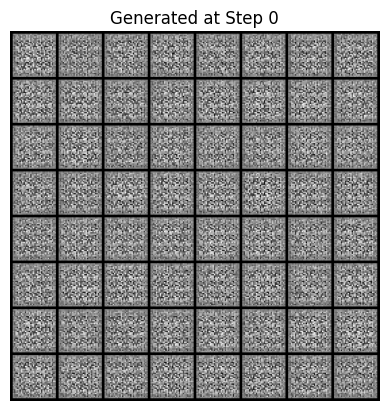

Step [400/2000] | discriminator_loss: 0.894 | generator_loss: 2.001:  20%|██        | 400/2000 [00:44<02:46,  9.62it/s]

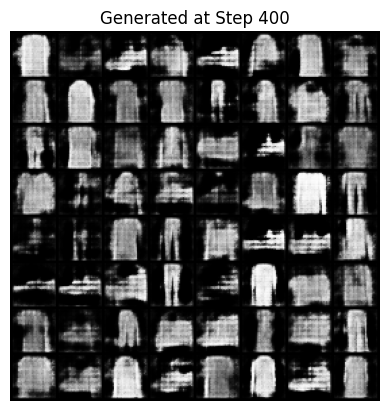

Step [800/2000] | discriminator_loss: 0.856 | generator_loss: 2.433:  40%|████      | 800/2000 [01:28<02:11,  9.11it/s]

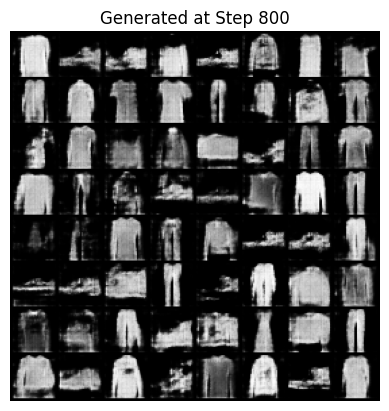

Step [1200/2000] | discriminator_loss: 1.027 | generator_loss: 1.527:  60%|██████    | 1200/2000 [02:13<01:33,  8.51it/s]

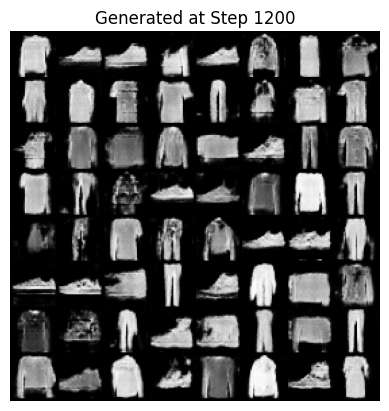

Step [1600/2000] | discriminator_loss: 0.715 | generator_loss: 1.949:  80%|████████  | 1600/2000 [02:59<00:44,  8.94it/s]

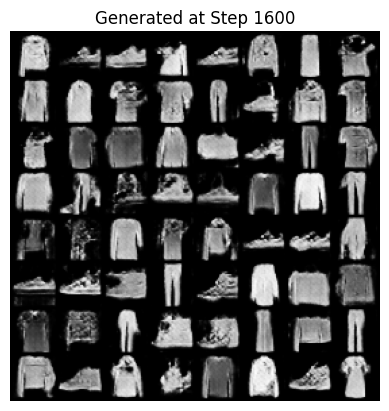

Step [1999/2000] | discriminator_loss: 0.553 | generator_loss: 2.246: 100%|██████████| 2000/2000 [03:45<00:00,  8.87it/s]


In [12]:
gan, D_losses, G_losses = train_gan("dcgan", device, train_dl)

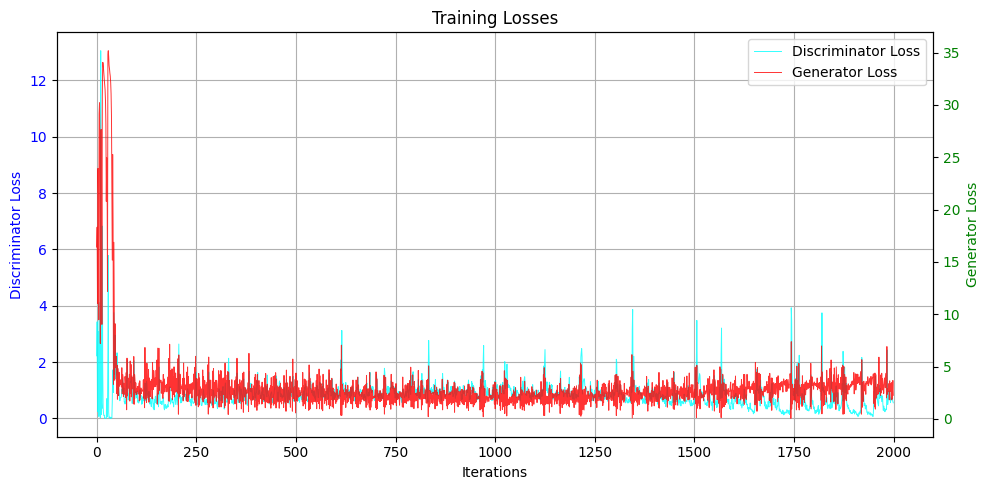

In [13]:
plot_loss(D_losses, G_losses)

Step [0/2000] | discriminator_loss: -41.642 | generator_loss: 41.886:   0%|          | 0/2000 [00:01<?, ?it/s]

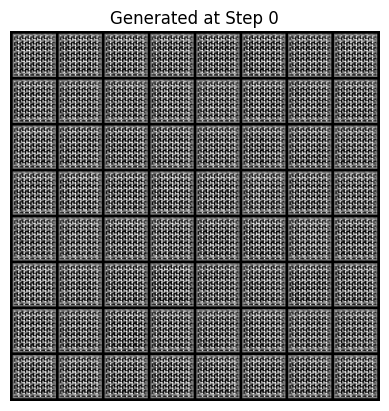

Step [400/2000] | discriminator_loss: -4.027 | generator_loss: 22.639:  20%|██        | 400/2000 [03:34<14:02,  1.90it/s]

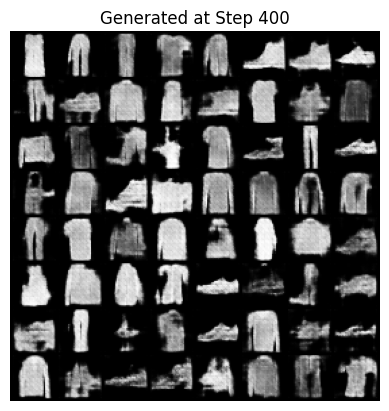

Step [800/2000] | discriminator_loss: -3.197 | generator_loss: 19.781:  40%|████      | 800/2000 [07:08<10:37,  1.88it/s]

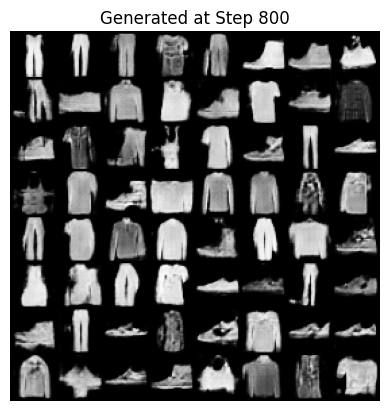

Step [1200/2000] | discriminator_loss: -7.061 | generator_loss: 22.944:  60%|██████    | 1200/2000 [10:42<07:10,  1.86it/s]

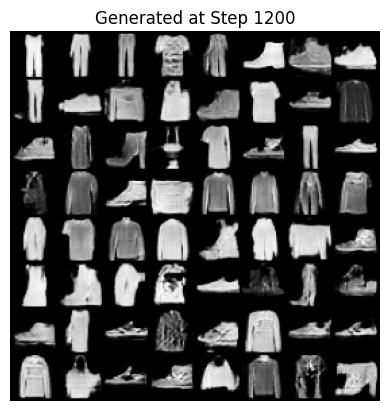

Step [1600/2000] | discriminator_loss: -6.570 | generator_loss: 20.923:  80%|████████  | 1600/2000 [14:16<03:36,  1.85it/s]

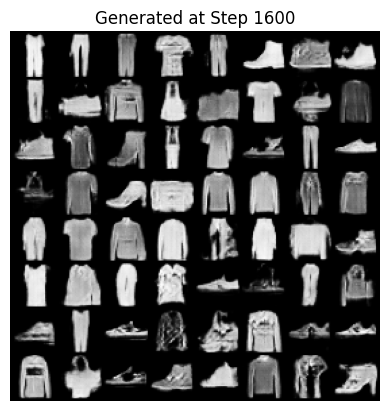

Step [1999/2000] | discriminator_loss: -4.879 | generator_loss: 15.179: 100%|██████████| 2000/2000 [17:50<00:00,  1.87it/s]


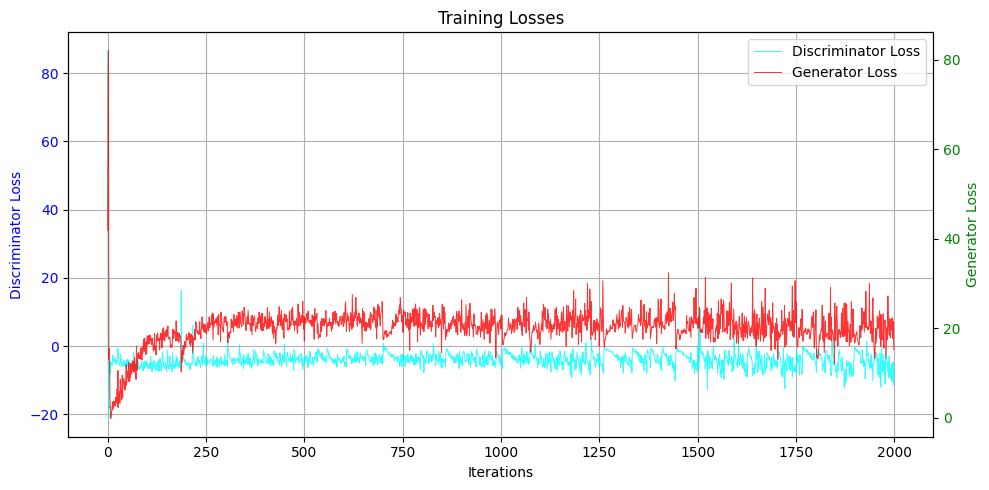

In [15]:
gan, D_losses, G_losses = train_gan("wgan", device, train_dl)


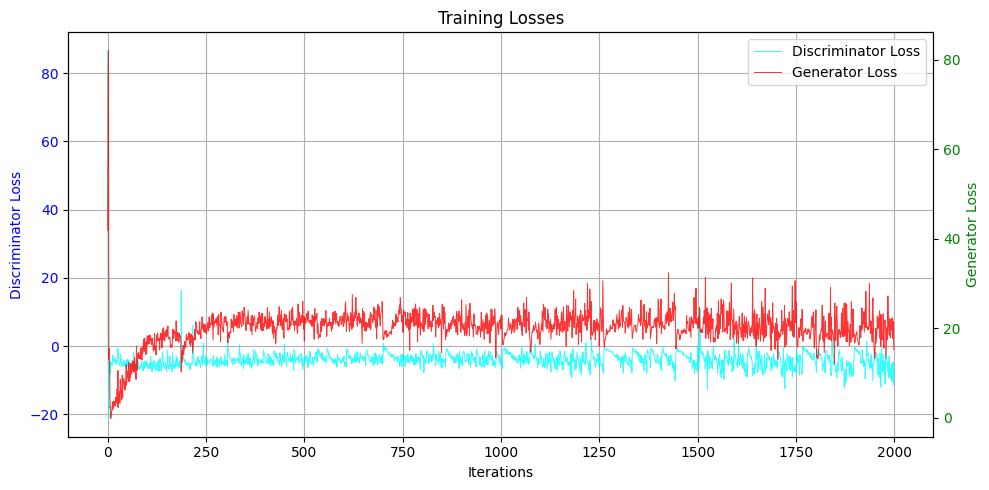

In [18]:
plot_loss(D_losses, G_losses)

In [25]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Load the saved model and plot fake samples
def load_model_and_generate(generator_path, device, train_dataset, num_samples=64, gan_architecture='dcgan'):
    """
    Load a saved GAN generator model, generate fake samples, and compare them with real samples.

    Args:
        generator_path (str): Path to the saved generator model.
        device (torch.device): Device to load the model and generate samples on (CPU or GPU).
        train_dataset (Dataset): Dataset to sample real images from.
        num_samples (int): Number of fake samples to generate. Default is 64.
        gan_architecture (str): Type of GAN architecture ('dcgan' or 'wgan'). Default is 'dcgan'.
    """
    # Latent vector size and learning rate (unused in loading but required for GAN initialization)
    nz = 128
    lr = 5e-4

    # Initialize the GAN model
    if gan_architecture == 'wgan':
        gan = WGAN(nz, lr, device)
    elif gan_architecture == 'dcgan':
        gan = DCGAN(nz, lr, device)
    else:
        raise ValueError(f"Unsupported GAN architecture: {gan_architecture}")

    # Load the generator's weights
    gan.generator.load_state_dict(torch.load(generator_path, map_location=device))
    gan.generator.eval()

    # Generate fake samples
    with torch.no_grad():
        noise = torch.randn(num_samples, nz, 1, 1, device=device)
        fake_images = gan.generator(noise).cpu()

    # Sample two real images from the dataset
    sample_idx1 = torch.randint(len(train_dataset), size=(1,)).item()
    sample_idx2 = torch.randint(len(train_dataset), size=(1,)).item()

    real_image1, label1 = train_dataset[sample_idx1]
    real_image2, label2 = train_dataset[sample_idx2]

    # Prepare real data for visualization
    real_images = torch.stack([real_image1, real_image2])  # Combine real samples into a single tensor
    # real_images = real_images.unsqueeze(1)  # Add a channel dimension if necessary

    # Log shapes of generated and real images
    print(f"Shape of fake_images: {fake_images.shape}")
    print(f"Shape of real_images: {real_images.shape}")

    # Plotting the fake and real images
    fig, axes = plt.subplots(2, 1, figsize=(15, 5))

    # Plot Generated Images
    axes[0].imshow(torchvision.utils.make_grid(fake_images, padding=2, normalize=True).permute(1, 2, 0))
    axes[0].set_title('Generated Images')
    axes[0].axis('off')

    # Plot Real Images
    axes[1].imshow(torchvision.utils.make_grid(real_images, padding=2, normalize=True).permute(1, 2, 0))
    axes[1].set_title('Real Images')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


#### Generation and Evaluation

Shape of fake_images: torch.Size([2, 1, 32, 32])
Shape of real_images: torch.Size([2, 1, 32, 32])


<ipython-input-25-2438121e8b0b>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gan.generator.load_state_dict(torch.load(generator_path, map_location=device))


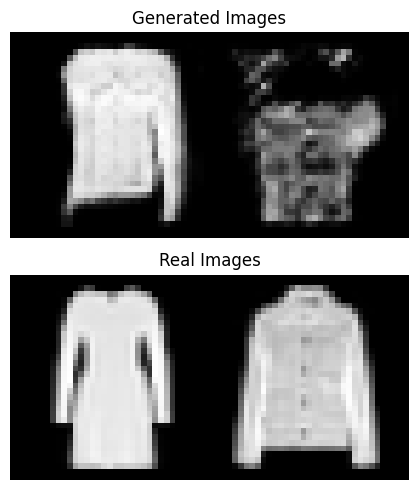

In [29]:
save_path = './saved_models'
generator_path = os.path.join(save_path, f'dcgan_generator.pth')
load_model_and_generate(generator_path, device, test_data,num_samples=2)

Shape of fake_images: torch.Size([2, 1, 32, 32])
Shape of real_images: torch.Size([2, 1, 32, 32])


<ipython-input-25-2438121e8b0b>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gan.generator.load_state_dict(torch.load(generator_path, map_location=device))


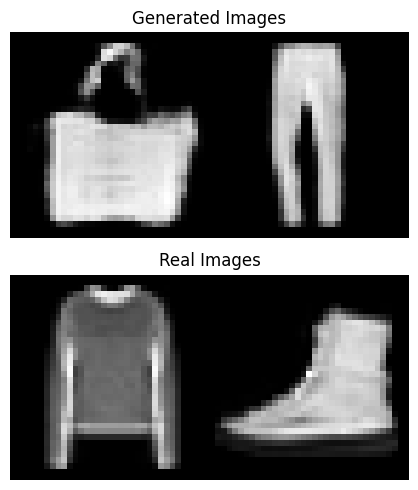

In [35]:
generator_path = os.path.join(save_path, f'wgan_generator.pth')
load_model_and_generate(generator_path, device, test_data,num_samples=2, gan_architecture="wgan")